In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import os

### The Yaleface Database
    Total number of persons photographed = 38
    Number of faces per person = 64
    Image size = 192 * 168 pixels

In [2]:
# reading faces of first 36 persons
imgs = os.listdir('CroppedYale')
imgs = imgs[0:36]                         # change here for number of persons
imgs = ['CroppedYale/'+x for x in imgs]

#### Some samples from data set

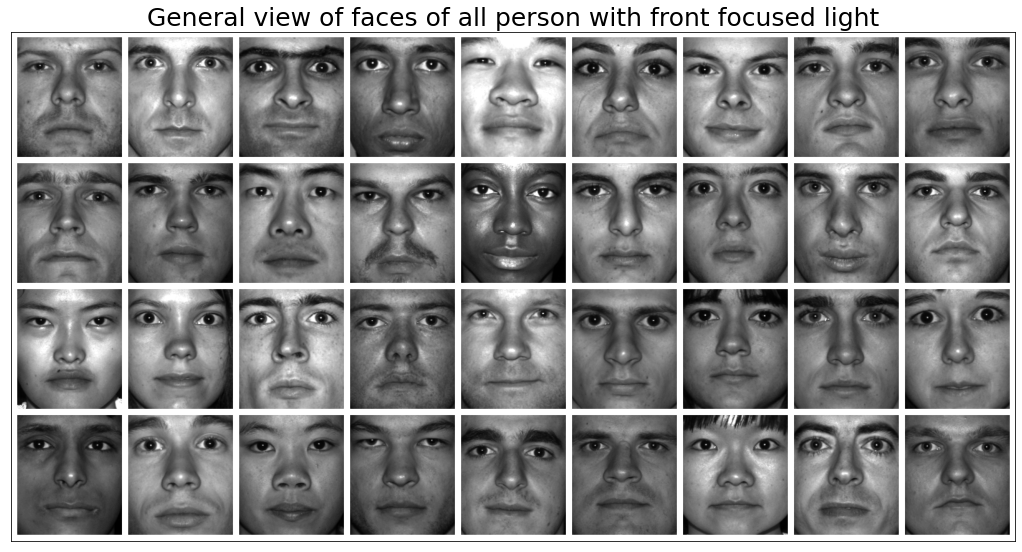

In [3]:
def faces9(x):
    faces = 255*np.ones((192,10))
    i = x
    while i < 9+x:
        ind = os.listdir(imgs[i])
        img = cv.imread(f'{imgs[i]}/{ind[0]}', 0)
        faces = np.hstack((faces, img, 255*np.ones((192,10))))
        i += 1
    return faces


faces36 = 255*np.ones((10, 168*9+100))
i = 0
while i < 36:
    faces36 = np.vstack((faces36, faces9(i), 255*np.ones((10, 168*9+100))))
    i += 9

plt.figure(figsize=(18,18))
plt.imshow(faces36, cmap='gray')
ax = plt.gca()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.set_title('General view of faces of all person with front focused light', fontsize=25)
plt.show()

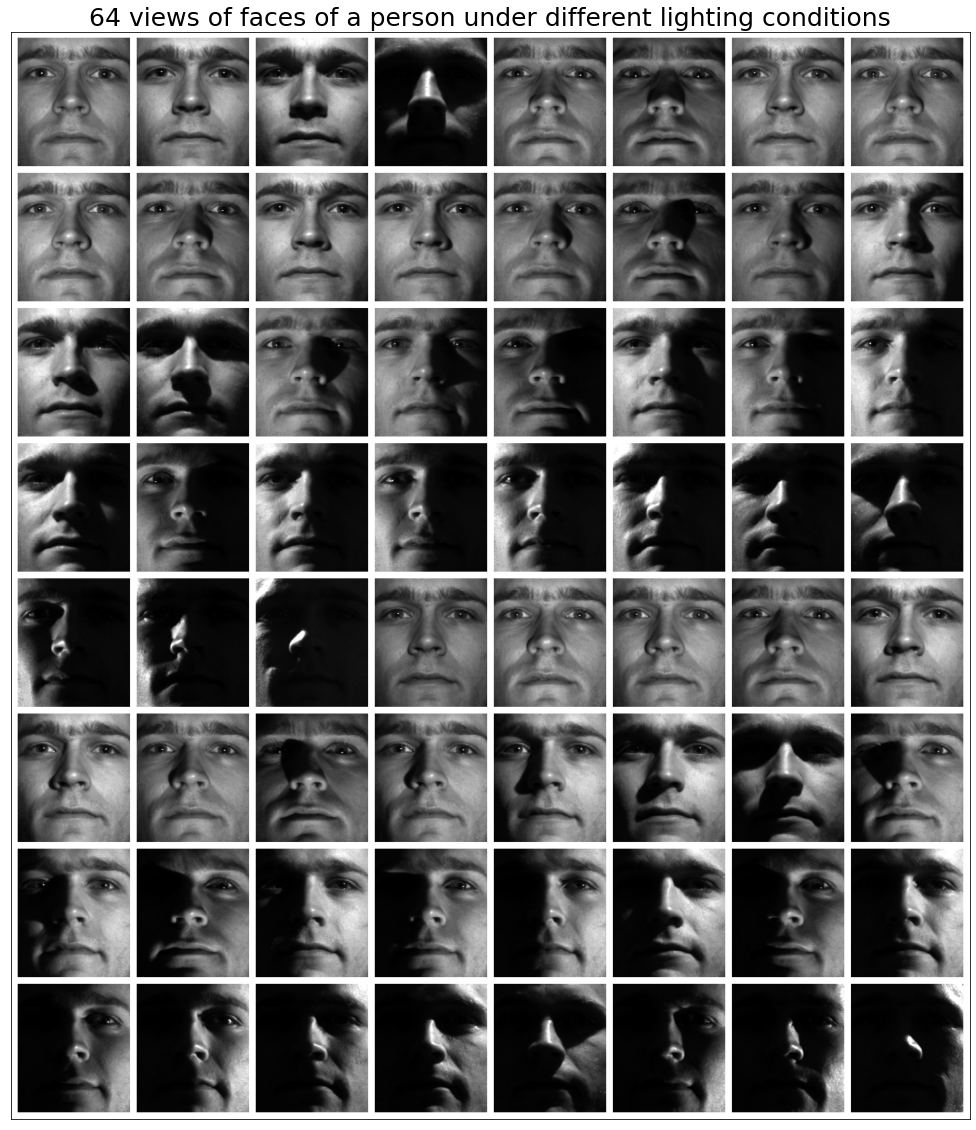

In [4]:
face_no = 9    # change here for faces

def faces8(x):
    faces = 255*np.ones((192,10))
    ind = os.listdir(imgs[face_no])     
    i = x
    while i < 8+x:
        img = cv.imread(f'{imgs[face_no]}/{ind[i]}', 0)
        faces = np.hstack((faces, img, 255*np.ones((192,10))))
        i += 1
    return faces

faces64 = 255*np.ones((10, 168*8+90))
i = 0
while i < 64:
    faces64 = np.vstack((faces64, faces8(i), 255*np.ones((10, 168*8+90))))
    i += 8

plt.figure(figsize=(20,20))
plt.imshow(faces64, cmap='gray')
ax = plt.gca()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.set_title('64 views of faces of a person under different lighting conditions', fontsize=25)
plt.show()

### Creating Pattern matrix

#### pattern (func.) 
    Input:1. Dataset (images of persons)
          2. Percent of dataset of each person to be used for training (fci - start index, fcf - end index of sample images)
    
    Working:
    vectorizes the images using raster scan order and stacks them together in a row to form a pattern matrix. 
    Separate pattern matrices are formed for each person and all those matrices are collected in one array.
    
    Returns: An array cointaining pattern matrices for each person

In [5]:
# fci - fcf - data set to be used for training. (Here, 80% data for each person was used for training, thus, fci=0, fcf=51)
def pattern(fci, fcf):
    # pattern matrix
    i = 0
    pco = []
    while i < len(imgs):
        ind = os.listdir(imgs[i])
        ind = ind[fci:fcf]
        pc = []
        for name in ind:
            img = cv.imread(f'{imgs[i]}/{name}', 0)
            pc.append(np.array(np.ndarray.flatten(img), dtype=float))
        pco.append(pc)
        i += 1
    return np.array(pco)

In [6]:
Pc = pattern(0, 51)
Ts = pattern(51, 64)

In [7]:
# a matrix of mean of each class
Pcm = []
i = 0
while i < len(Pc):
    Pcm.append(np.mean(Pc[i], axis=0))
    i += 1
Pcm = np.array(Pcm)

In [8]:
Pmen = np.mean(Pcm, axis = 0)

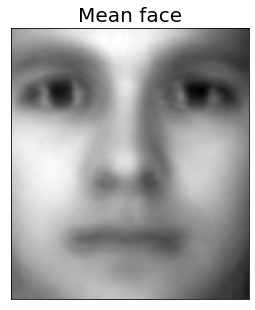

In [9]:
plt.figure(figsize=(5, 5))
plt.imshow(Pmen.reshape(192,168), cmap='gray')
ax = plt.gca()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.set_title('Mean face', fontsize=20)
plt.show()

### dim_red (func.)
    Reduces the dimension of original Pattern Matrix using SVD.
    
    Input - 1. Labelled Train Pattern matrix
            2. Labelled Test Pattern matrix
            3. Matrix of class means
            4. Number of components to kept after dimensionality reduction. 
            (Number of columns of Left singular value matrix to be used.)
    
    Retruns: Dimensionally reduced Test and Train Pattern matrix, class means matrix and normalised reduced pattern matrix

In [10]:
# pc - labelled train pattern matrix
# ts - labelled test pattern matrix
# pcm - class means matrix
# n_coms - dimension of new space

def dim_red(pc, ts, pcm, n_coms):
    p = pc[0]
    i = 1
    while i< len(pc):
        p = np.vstack((p, pc[i]))
        i += 1
    
    # mean of data
    mn = np.mean(p, axis=0)
    
    # mean normalization
    pm = p - mn
    
    # matrix decomposition using SVD
    u1, c1, v1t = np.linalg.svd(pm.T, full_matrices=False)
    
    # projections of train-pattern matrix under SVD basis
    ic = []
    i = 0
    while i < len(pc):
        ic.append(np.matmul(pc[i], u1[:, 0:n_coms]))
        i += 1
    ic = np.array(ic)
    
    # projections of test-pattern matrix under SVD basis
    ti = []
    i = 0
    while i < len(ts):
        ti.append(np.matmul(ts[i], u1[:, 0:n_coms]))
        i += 1
    ti = np.array(ti)
    
    # projections of class means under SVD basis
    im = []
    i = 0
    while i < len(pcm):
        im.append(np.matmul(pcm[i], u1[:, 0:n_coms]))
        i += 1
    im = np.array(im)
    
    # class mean normalised train-pattern matrix 
    npc = []
    i = 0
    while i < len(pcm):
        npc.append(pc[i] - pcm[i])
        i += 1
    npc = np.array(npc)
    
    # projections of mean normalised train-pattern matrix
    nic = []
    i = 0
    while i < len(npc):
        nic.append(np.matmul(npc[i], u1[:, 0:n_coms]))
        i += 1
    nic = np.array(nic)
    
    return ic, ti, im, nic, u1

In [11]:
# Ic - dimensionally reduced train pattern matrix
# It - dimensionally reduced test pattern matrix
# Im - dimensionally reduced class means matrix
# Icm - dimensionally reduced normalized train pattern matrix
components = 40
Ic, It, Im, Icm, U1 = dim_red(Pc, Ts, Pcm, components)   # last input value is the number of components

### Eigen faces (vectors from U1 matrix converted into images)

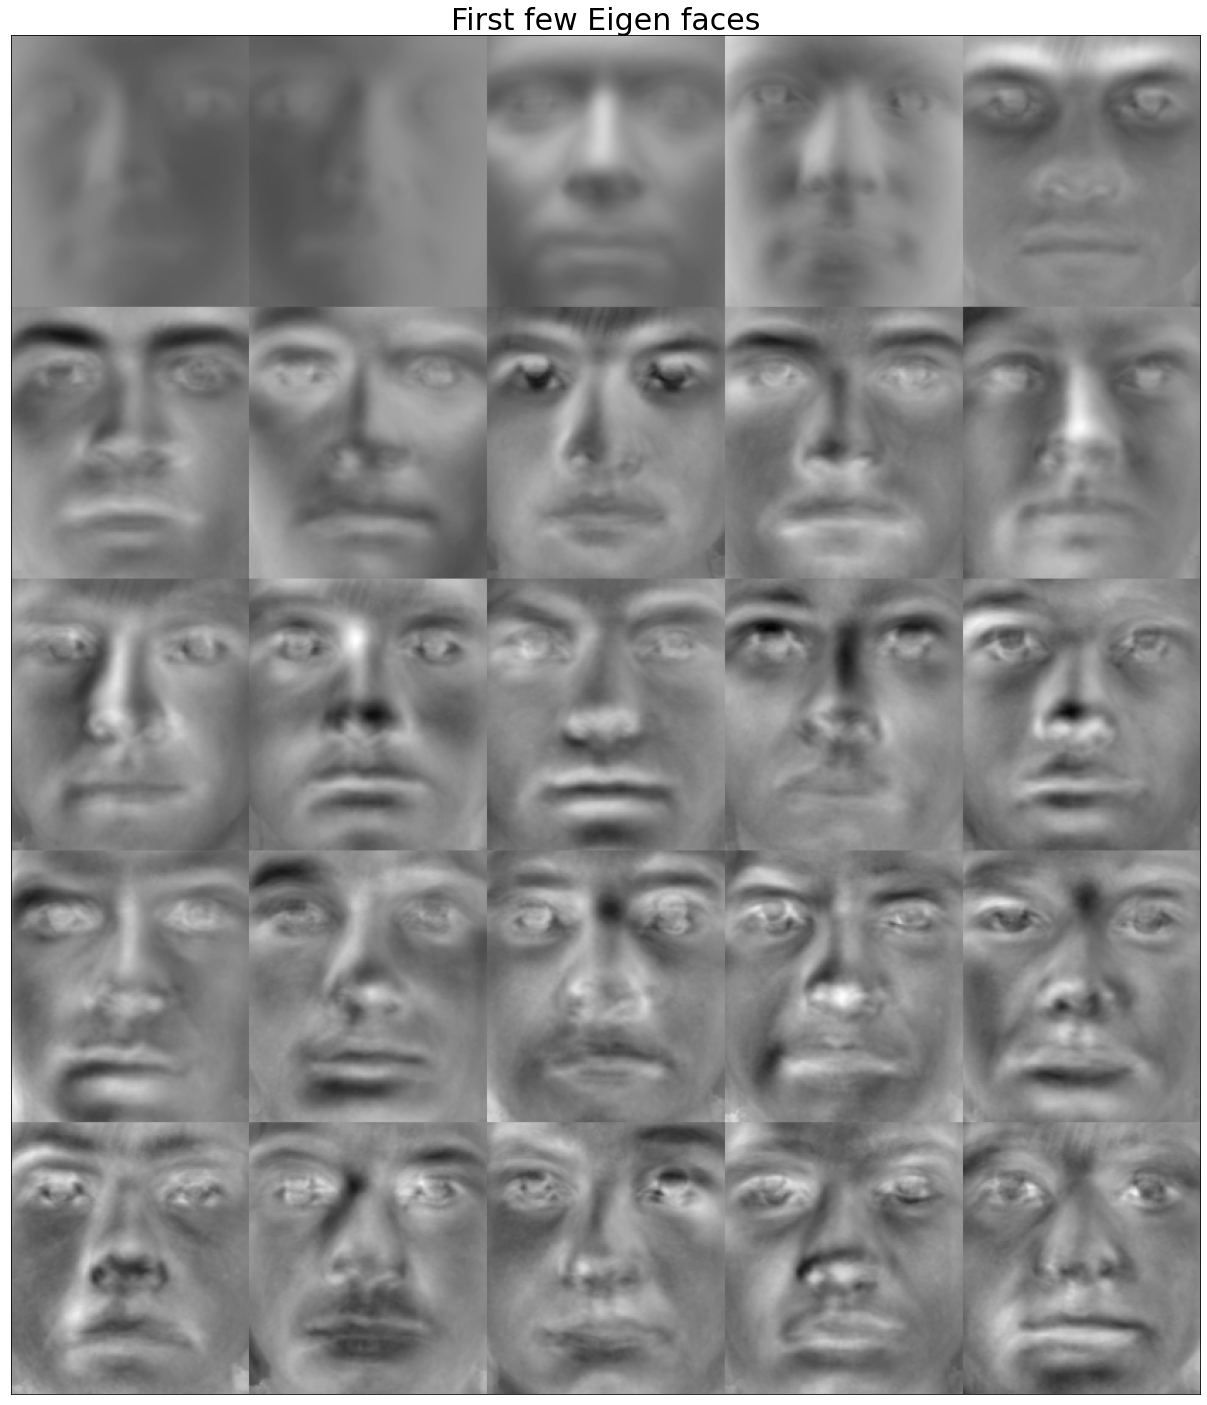

In [12]:
def eif5(x):
    faces = U1[:, x].reshape(192,168)
    i = x+1
    while i < 5+x:
        img = U1[:, i].reshape(192,168)
        faces = np.hstack((faces, img))
        i += 1
    return faces

eif20 = eif5(0)
i = 5
while i < 25:
    eif20 = np.vstack((eif20, eif5(i)))
    i += 5

plt.figure(figsize=(25, 25))
plt.imshow(eif20, cmap='gray')
ax = plt.gca()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.set_title('First few Eigen faces', fontsize=30)
plt.show()

#### Some more eigen faces - deciding the number of basis for new space (Dimensionality reduction)

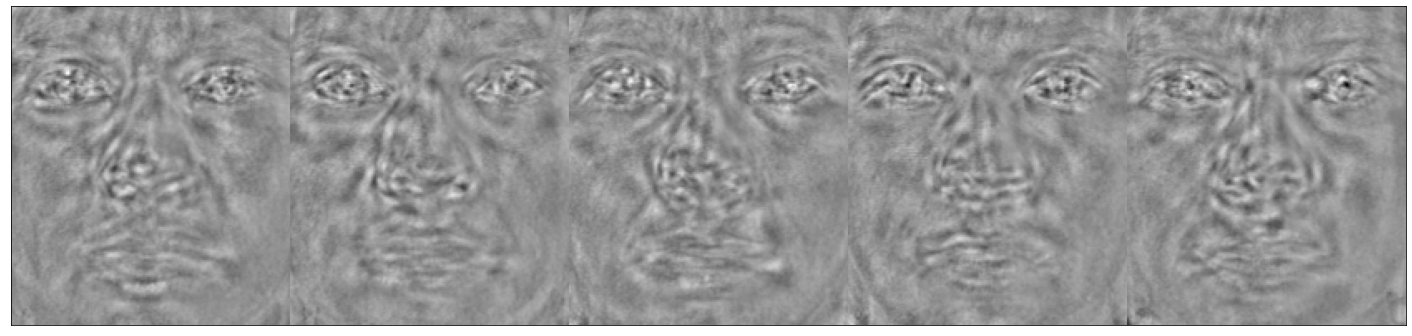

In [13]:
plt.figure(figsize=(25, 25))
plt.imshow(eif5(300), cmap='gray')
ax = plt.gca()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.show()

#### Abstractions from data

In [14]:
# corr. matrices for each face
cor = []
i = 0
while i < Ic.shape[0]:
    cor.append(np.matmul(Icm[i].T,Icm[i]))
    i += 1
cor = np.array(cor)

#### accuracy (func.)
    A new test point is assigned to a class based on the mahalanobis distance of the test point from all the clusture centroids. The test point is assigned to class whose centriod has minimum distance from test point. Then the number of faces correctly classified is calculated and converted into percent resulting in accuracy.
    
    Inputs: 1. Pattern Matrix
    
    Returns: Accuracy

In [15]:
def accuracy(tm):
    fno = 0
    ft = []
    while fno < len(imgs):
        tr = 0
        j = 0
        while j < tm.shape[1]:
            dist = []
            i = 0
            while i < tm.shape[0]:
                dist.append(((tm[fno][j] - Im[i]).reshape(1, len(Im[i])) @ (np.linalg.inv(cor[i]) @ (tm[fno][j] - Im[i]).reshape(len(Im[i]), 1)))[0][0])
                i += 1
            if np.argsort(dist)[0] == fno:
                tr += 1
            j += 1
        ft.append([fno, tr])
        fno += 1
    return 100 * sum(np.array(ft)[:, 1])/(len(imgs)*tm.shape[1])

In [16]:
Train_set_accuracy = accuracy(Ic)
Test_set_accuracy = accuracy(It)

In [17]:
print(f'The train set accuracy is {Train_set_accuracy} for {components} components of left singular vectors (U vectors) as obtained from SVD')

The train set accuracy is 99.40087145969498 for 40 components of left singular vectors (U vectors) as obtained from SVD


In [18]:
print(f'The test set accuracy is {Test_set_accuracy} for {components} components of left singular vectors as obtained from SVD ')

The test set accuracy is 48.29059829059829 for 40 components of left singular vectors as obtained from SVD 


### Some plots for checking class separation

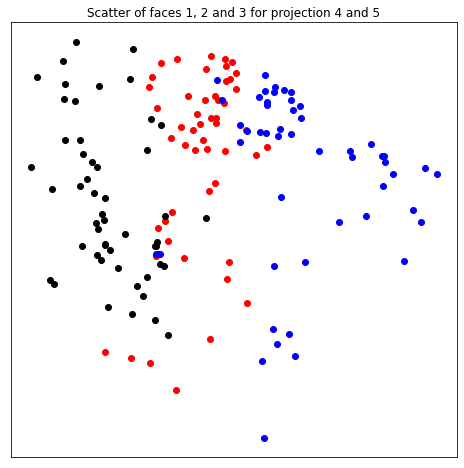

In [19]:
f1 = 1   # select face 1
f2 = 2   # select face 2
f3 = 3   # select face 2
p1 = 4   # select projection component 1
p2 = 5   # select projection component 2
plt.figure(figsize=(8,8))
plt.scatter(Ic[f1,:, p1], Ic[f1,:, p2], c='red')
plt.scatter(Ic[f2,:, p1], Ic[f2,:, p2], c='blue')
plt.scatter(Ic[f3,:, p1], Ic[f3,:, p2], c='black')
plt.title(f'Scatter of faces {f1}, {f2} and {f3} for projection {p1} and {p2}')
ax = plt.gca()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.show()

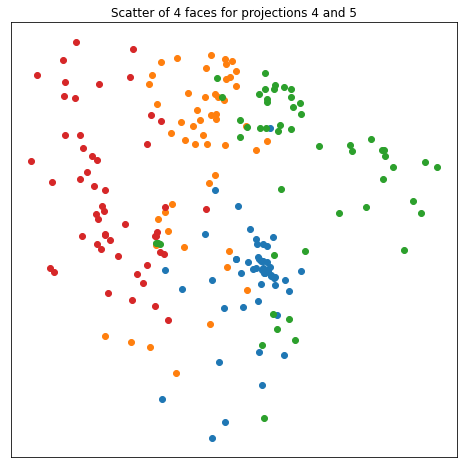

In [20]:
plt.figure(figsize=(8,8))
kk = 4          # select number of faces here
i = 0           # select starting face here
while i < kk:   
    plt.scatter(Ic[i,:, p1], Ic[i,:, p2])
    i += 1
plt.title(f'Scatter of {kk} faces for projections {p1} and {p2}')
ax = plt.gca()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.show()

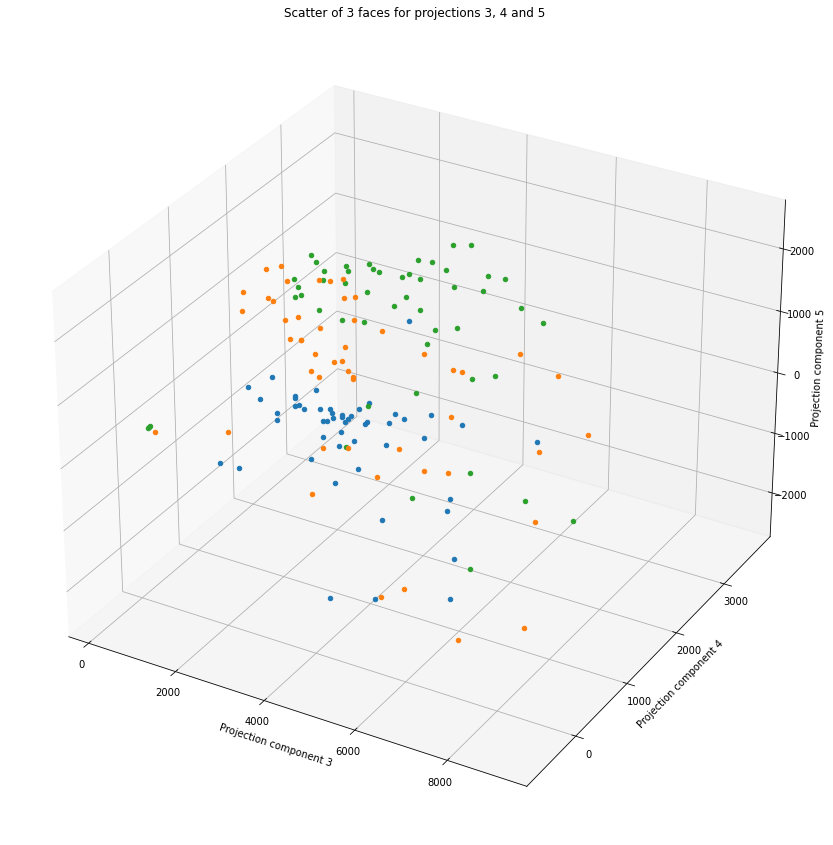

In [21]:
# projection componenets
p1 = 3
p2 = 4
p3 = 5
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111, projection="3d")
i = 0
while i < 3:
    ax.scatter3D(Ic[i,:,p1], Ic[i,:,p2], Ic[i,:,p3], depthshade=False)
    i += 1
ax.set_xlabel(f'Projection component {p1}')
ax.set_ylabel(f'Projection component {p2}')
ax.set_zlabel(f'Projection component {p3}')
ax.set_title(f'Scatter of {i} faces for projections {p1}, {p2} and {p3}')
plt.show()